In [1]:
import argparse
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

os.chdir('/Users/yanting/OneDrive/Desktop/2023_11_18 Hackathon/2023_11_18-SE-Europe-Data_Challenge')

os.chdir('./src')
import data_processing

os.chdir('/Users/yanting/OneDrive/Desktop/2023_11_18 Hackathon/2023_11_18-SE-Europe-Data_Challenge')

FileNotFoundError: [WinError 3] Das System kann den angegebenen Pfad nicht finden: '/Users/yanting/OneDrive/Desktop/2023_11_18 Hackathon/2023_11_18-SE-Europe-Data_Challenge'

In [ ]:
df_dict = data_processing.load_data('/Users/yanting/OneDrive/Desktop/2023_11_18 Hackathon/2023_11_18-SE-Europe-Data_Challenge/data')

In [ ]:
df_dict_clean = data_processing.clean_data(df_dict)

In [ ]:
regions = {
    'HU': '10YHU-MAVIR----U',
    'IT': '10YIT-GRTN-----B',
    'PO': '10YPL-AREA-----S',
    'SP': '10YES-REE------0',
    'UK': '10Y1001A1001A92E',
    'DE': '10Y1001A1001A83F',
    'DK': '10Y1001A1001A65H',
    'SE': '10YSE-1--------K',
    'NE': '10YNL----------L',
}

reversed_regions = {v: k for k, v in regions.items()}

# given set of green energy types
green_energy_types_list = ["B01", "B09", "B10", "B11", "B12", "B13", "B15", "B16", "B18", "B19"]

# dictionary to map country codes to indices
country_codes_dict = {'SP': 0, 'UK': 1, 'DE': 2, 'DK': 3, 'SE': 4, 'HU': 5, 'IT': 6, 'PO': 7, 'NL': 8}

def preprocess_data(df_dict):
    
    """ 
    Generates new features, transform existing features, resampling & aggregate, etc. 
    """

    df_processed = pd.DataFrame()
    country_list = []

    for df_name, df in df_dict.items(): 

        # len index because UK has columns but no values
        # so df.empty returns FALSE
        if (len(df.index) == 0) :
            print('-'*15)
            print(f'{df_name} is empty')
            print('-'*15)
            continue
        
        # all csv files (gen and load) have column AreaID and UnitName
        UnitName = df['UnitName'][0]
        country = df_name.split('_')[1] # alternative
        # add country to country_list if its new
        if country not in country_list:
            country_list.append(country)

        # determine whether its gen or load file
        if df_name.startswith('load') : pwr_type = 'load'
        else : pwr_type = df['PsrType'][0]

        # resample (aggregate) to hourly level and sum
        df_resampled = df.resample("1h", label="left").sum()
        # assign new column name including country, power type and unit information
        new_name = f"{country}_{pwr_type}_{UnitName}"
        df_resampled.rename(columns={df_resampled.columns[0]: new_name}, inplace=True)

        # concatenate to output dataframe
        df_processed = pd.concat([df_processed, df_resampled], axis=1)
    
    for country in country_list :
        # take the sum over all green energies
        green_columns = [col for col in df_processed.columns 
                         if col.startswith(f"{country}_") 
                         and any(energy_type in col for energy_type in green_energy_types_list)]
        
        # sum of green energies
        df_processed[f"{country}_green_MAW"] = df_processed[green_columns].sum(axis=1)
        
        # green energy surplus = difference between DE_green_MAW and DE_load_MAW
        load_column = f"{country}_load_MAW"
        df_processed[f"{country}_green_surplus_MAW"] = df_processed[f"{country}_green_MAW"] - df_processed[load_column]

    # add column with the country that has the highest surplus of green energy at each hour
    df_processed['max_surplus_country_name'] = df_processed.apply(lambda row: max(country_list, key=lambda country: row[f"{country}_green_surplus_MAW"]), axis=1)

    # map the country code based on the order defined in country_code_order
    df_processed['max_surplus_country_code'] = df_processed['max_surplus_country_name'].map(country_codes_dict)

    df_processed['max_surplus_country_code_next_hr'] = df_processed['max_surplus_country_code'].shift(-1)

    return df_processed

In [ ]:
df_prepro = preprocess_data(df_dict)
print(df_prepro.columns)
print(f"{len(df_prepro)} hours out of {365*24}")

Index(['SP_load_MAW', 'DE_B09_MAW', 'DE_B20_MAW', 'SE_load_MAW', 'NE_B20_MAW',
       'NE_B18_MAW', 'NE_B19_MAW', 'DK_load_MAW', 'DE_B18_MAW', 'DE_B19_MAW',
       ...
       'PO_green_surplus_MAW', 'HU_green_MAW', 'HU_green_surplus_MAW',
       'IT_green_MAW', 'IT_green_surplus_MAW', 'UK_green_MAW',
       'UK_green_surplus_MAW', 'max_surplus_country_name',
       'max_surplus_country_code', 'max_surplus_country_code_next_hr'],
      dtype='object', length=135)
8761 hours out of 8760


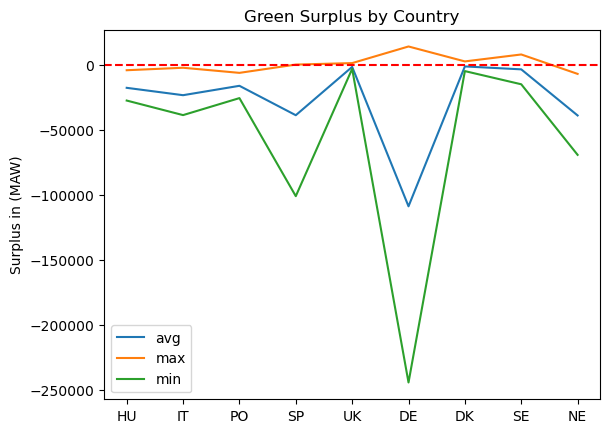

In [ ]:
country_labels = ['HU', 'IT', 'PO', 'SP', 'UK', 'DE', 'DK', 'SE', 'NE']
avg_surplus_by_country = [df_prepro[f"{country}_green_surplus_MAW"].mean() for country in country_labels]
max_surplus_by_country = [df_prepro[f"{country}_green_surplus_MAW"].max() for country in country_labels]
min_surplus_by_country = [df_prepro[f"{country}_green_surplus_MAW"].min() for country in country_labels]

plt.plot(avg_surplus_by_country, label='avg')
plt.plot(max_surplus_by_country, label='max')
plt.plot(min_surplus_by_country, label='min')
plt.axhline(y=0, color='red', linestyle='--')

plt.xticks(range(9), country_labels)
plt.ylabel('Surplus in (MAW)')
plt.title('Green Surplus by Country')

plt.legend()
plt.show()

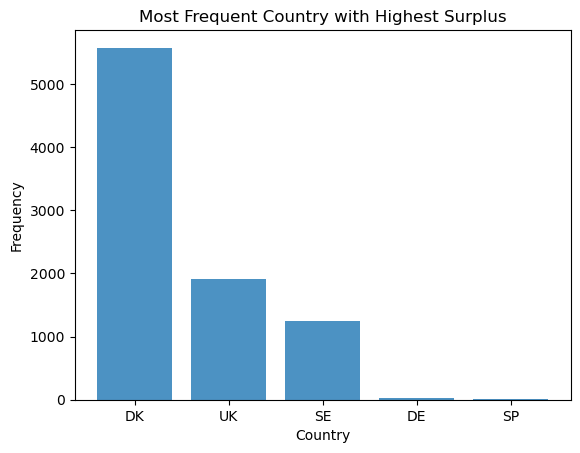

In [ ]:
# Count the occurrences of each country
country_counts = df_prepro['max_surplus_country'].value_counts()
# Sort the countries based on their counts
sorted_countries = country_counts.sort_values(ascending=False).index

# Plot a bar plot
plt.bar(range(len(sorted_countries)), country_counts[sorted_countries], align='center', alpha=0.8)
plt.xlabel('Country')
plt.ylabel('Frequency')
plt.title('Most Frequent Country with Highest Surplus')
plt.xticks(range(len(sorted_countries)), sorted_countries)
plt.show()

In [ ]:
df_prepo_DE = df_prepro[[col for col in df_prepro.columns if col.startswith("DE")]]
df_prepo_DE = df_prepo_DE.reindex(sorted(df_prepo_DE.columns), axis=1)
df_prepo_DE.to_csv("df_prepo_DE.csv")

In [ ]:
df_prepro.columns[df_prepro.describe().loc['count'].argmin()]